In [1]:
# Modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as sns

# Feature Selection
import xgboost as xgb
from sklearn.decomposition import PCA

# Evaluate Algorithms

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
from acquire_prepare import acquire_oil
from acquire_prepare import prep_data

import model
from model import polynomial_regression_model
from model import run_models

import numpy as np
import pandas as pd

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import sys 

**Let's bring in the DataFrame**

In [3]:
df = acquire_oil()
df = prep_data(df)

**(Rows, Columns)**

In [4]:
df.shape

(7808, 62)

### XGBoost Feature Recommender

In [10]:
xgb_df = scaled_df.copy()

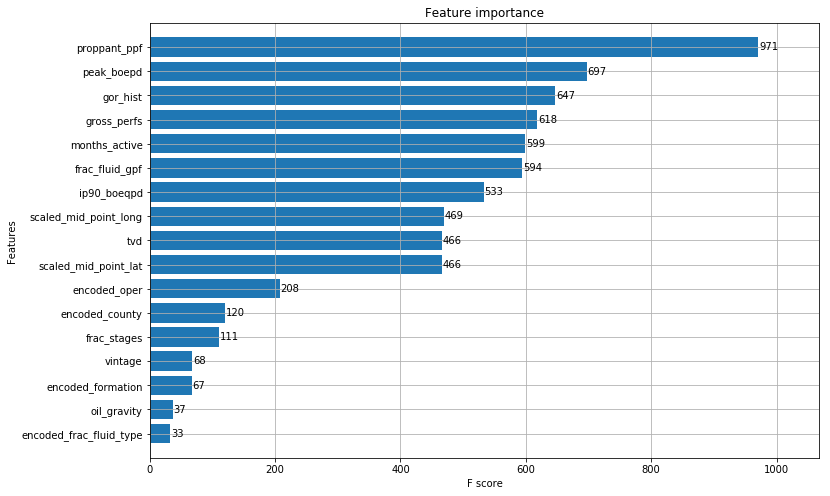

In [11]:
xgb_params = {
    'max_depth': 8,
    'seed' : 493
}

dtrain = xgb.DMatrix(xgb_df, df.oil_hist, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

# Test Harness and Options

In [21]:
# xfeatures = ['proppant_ppf', 'frac_fluid_gpf', 'gor_hist', 'tvd', 'mid_point_lat', 'mid_point_long', 'encoded_oper', 'encoded_direction', 'vintage', 'gross_perfs']
# yfeature = ['recovery']

In [22]:
xfeatures = ['proppant_ppf', 'gross_perfs', 'tvd', 'frac_fluid_gpf', 'gor_hist', 'encoded_oper', 'vintage']
yfeature = ['recovery']

In [23]:
df_normalize = model.normalize(df, xfeatures)

### Results for the entire dataframe to use as a baseline before clustering

Logistic Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 108.81744595189436
R2 score of training set is 0.22183715915946423


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.19798066 0.21715872 0.24588504]


The model performance for the test set
-------------------------------------------
RMSE of test set is 107.67315740779856
R2 score of test set is 0.20252950253228708




Ridge Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 108.56838205214586
R2 score of training set is 0.2253952369854828


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.20050515 0.21981259 0.24839826]


The model performance for the test set
-------------------------------------------
RMSE of test set is

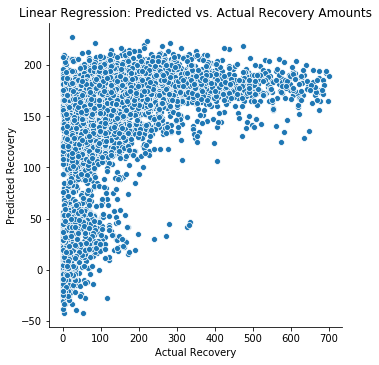

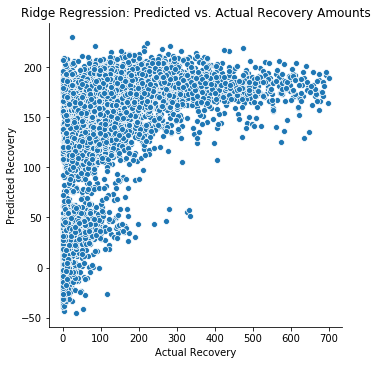

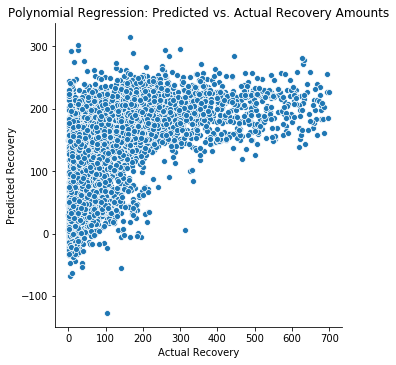

In [24]:
model.run_models(df_normalize, xfeatures, yfeature, 0.80)

**Let's Cluster by our Top Seven features per our XGBoost function**

In [25]:
# col_list = ['scaled_proppant_ppf', 'scaled_gross_perfs', 'scaled_tvd', 'scaled_frac_fluid_gpf', 
#             'scaled_gor_hist', 'encoded_oper', 'scaled_vintage']

In [26]:
col_list = ['proppant_ppf', 'gross_perfs', 'tvd', 'frac_fluid_gpf', 
            'gor_hist', 'encoded_oper', 'vintage']

**We now have a new dataframe with an added column "cluster_id"**

In [27]:
df = model.create_kclusters(df, col_list, 3, 'cluster_id')

**Let's see how many oberservations we have in each cluster**

In [28]:
df.cluster_id.value_counts()

2    4474
0    2110
1    1224
Name: cluster_id, dtype: int64

In [29]:
df.to_excel('CapstoneDataFinal.xlsx')

# ALL Regression Types on Each Cluster

### Cluster 0: 4,862 Oberservations 

In [30]:
cluster_zero = df[df['cluster_id'] == 0]

Logistic Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 102.38282437313508
R2 score of training set is 0.15149842094989974


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.1371502  0.13581364 0.15724899]


The model performance for the test set
-------------------------------------------
RMSE of test set is 97.19972345220971
R2 score of test set is 0.1197974663341067




Ridge Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 102.39823456604806
R2 score of training set is 0.15124297659899766


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.13695481 0.13559365 0.15686097]


The model performance for the test set
-------------------------------------------
RMSE of test set is 

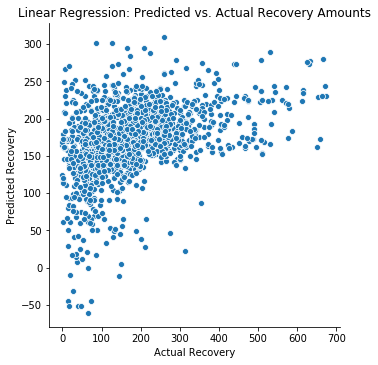

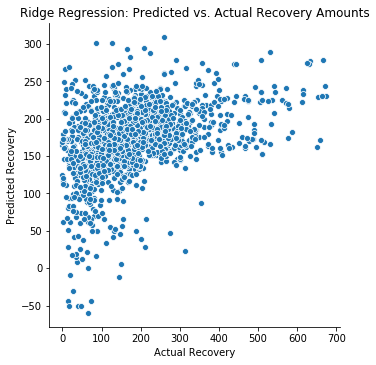

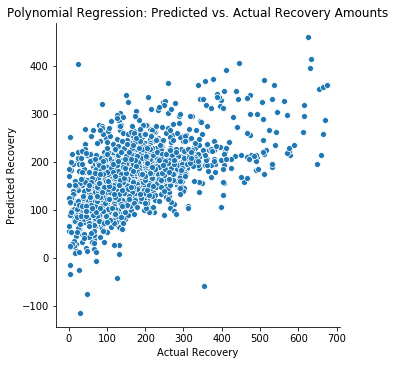

In [31]:
model.run_models(cluster_zero, xfeatures, yfeature, 0.70)

### Cluster 1: 1,714 Observations

In [32]:
cluster_one = df[df['cluster_id'] == 1]

Logistic Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 39.13068888696563
R2 score of training set is 0.14179091786481213


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.08241126 0.11946941 0.15282091]


The model performance for the test set
-------------------------------------------
RMSE of test set is 43.38895000636832
R2 score of test set is 0.14030919655257046




Ridge Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 38.05389161861736
R2 score of training set is 0.1883733985158006


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.11833936 0.15397447 0.18287368]


The model performance for the test set
-------------------------------------------
RMSE of test set is 42

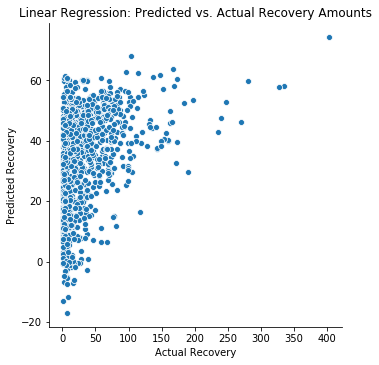

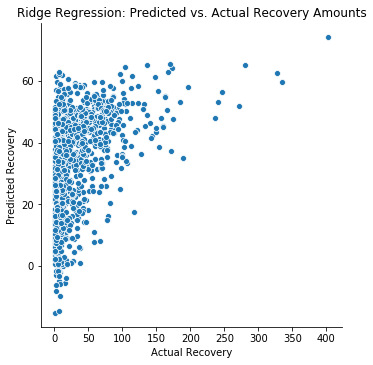

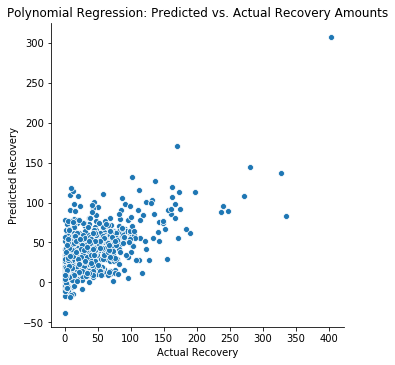

In [33]:
model.run_models(cluster_one, xfeatures, yfeature, 0.70)

### Cluster 2: 1,232 Observations

In [34]:
cluster_two = df[df['cluster_id'] == 2]

Logistic Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 115.30411701739563
R2 score of training set is 0.15337519801596433


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.12704661 0.15707645 0.16062057]


The model performance for the test set
-------------------------------------------
RMSE of test set is 124.82796962795305
R2 score of test set is 0.13139142251689717




Ridge Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 115.30705855125352
R2 score of training set is 0.15333200081970644


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.12700658 0.15703735 0.16051282]


The model performance for the test set
-------------------------------------------
RMSE of test set i

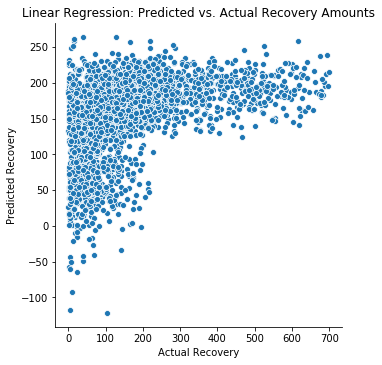

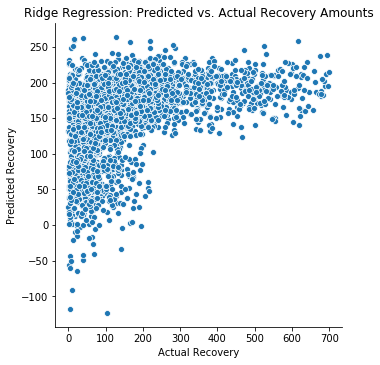

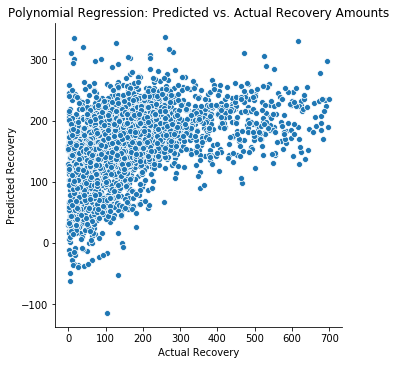

In [35]:
model.run_models(cluster_two, xfeatures, yfeature, 0.70)

## Interpret and report results

# Improve Results

## Algorithm Tuning

## Ensemble Methods

### Bagging

### Boosting

### Blending

## Extreme Feature Engineering